## A3 - Utah Teapot in World Space

The Utah teapot is placed into world space (with a camera). The view of the teapot can be modified simply by changing the coordinates of the camera (as opposed to changing the coordinates in object space).

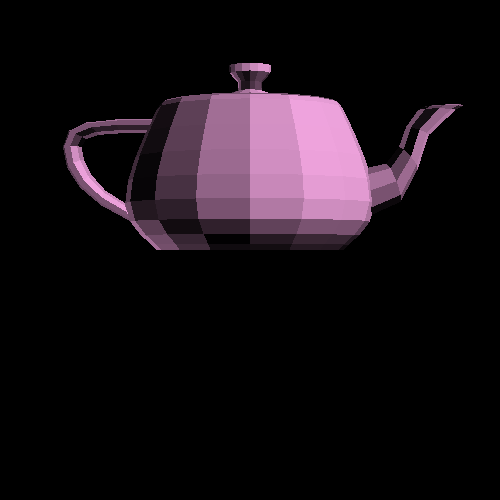

In [4]:
def main():
    teapot = Model("a3-teapot.json")
    camera = Camera(
        u=[1, 0, 0],
        v=[0, 1, 0],
        n=[0, 0, 1],
        r=[0, 0, 20],
    )

    bounds = Bounds(left=-1, right=1, top=1, bottom=-1, near=5, far=7)

    canvas = Canvas()
    canvas.set_camera(camera)
    canvas.set_bounds(bounds)

    canvas.add_models([teapot])
    canvas.draw_models()
    display(canvas.im)


if __name__ == "__main__":
    main()

In [1]:
import json
import sys

import numpy as np
from PIL import Image


class Camera:
    def __init__(self, u: list[float], v: list[float], n: list[float], r: list[float]):
        self.u = np.array(u)
        self.v = np.array(v)
        self.n = np.array(n)
        self.r = np.array(r)


class Bounds:
    def __init__(
        self,
        left: float,
        right: float,
        top: float,
        bottom: float,
        near: float,
        far: float,
    ):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        self.near = near
        self.far = far


class Vertex:
    def __init__(self, vertex_json):
        # Vertex coordinates
        # Append the homogeneous coordinate
        self.v = np.concatenate((vertex_json["v"], [1]), dtype=np.float64)

        # Vertex normals
        self.n = np.array(vertex_json["n"], dtype=np.float64)

        # Texture coordinate
        self.t = np.array(vertex_json["t"], dtype=np.float64)


class Triangle:
    def __init__(self, triangle_json: object):
        self.vertices: list[Vertex] = []
        for _, vertex_json in triangle_json.items():
            self.vertices.append(Vertex(vertex_json))

        self.compute_color()

    def x_min(self):
        return min(self.vertices, key=lambda vertex: vertex.v[0]).v[0]

    def x_max(self):
        return max(self.vertices, key=lambda vertex: vertex.v[0]).v[0]

    def y_min(self):
        return min(self.vertices, key=lambda vertex: vertex.v[1]).v[1]

    def y_max(self):
        return max(self.vertices, key=lambda vertex: vertex.v[1]).v[1]

    def compute_color(self):
        dot_p = np.dot([0.707, 0.5, 0.5], self.vertices[0].n)

        if dot_p < 0:
            dot_p *= -1
        elif dot_p > 1.0:
            dot_p = 1.0

        self.color = (
            int(0.95 * dot_p * 255),
            int(0.65 * dot_p * 255),
            int(0.88 * dot_p * 255),
        )

        self.color = tuple((255 * np.dot([0.95, 0.65, 0.88], dot_p)).astype(int))

    def f01(self, x: np.float64, y: np.float64):
        # f01(x,y) = (y0-y1)x + (x1-x0)y + x0y1-x1y0
        return (
            (self.vertices[0].v[1] - self.vertices[1].v[1]) * x
            + (self.vertices[1].v[0] - self.vertices[0].v[0]) * y
            + (self.vertices[0].v[0] * self.vertices[1].v[1])
            - (self.vertices[1].v[0] * self.vertices[0].v[1])
        )

    def f12(self, x: np.float64, y: np.float64):
        # f12(x,y) = (y1-y2)x + (x2-x1)y + x1y2-x2y1
        return (
            (self.vertices[1].v[1] - self.vertices[2].v[1]) * x
            + (self.vertices[2].v[0] - self.vertices[1].v[0]) * y
            + (self.vertices[1].v[0] * self.vertices[2].v[1])
            - (self.vertices[2].v[0] * self.vertices[1].v[1])
        )

    def f20(self, x: np.float64, y: np.float64):
        # f20(x,y) = (y2-y0)x + (x0-x2)y + x2y0-x0y2
        return (
            (self.vertices[2].v[1] - self.vertices[0].v[1]) * x
            + (self.vertices[0].v[0] - self.vertices[2].v[0]) * y
            + (self.vertices[2].v[0] * self.vertices[0].v[1])
            - (self.vertices[0].v[0] * self.vertices[2].v[1])
        )


class Model:
    def __init__(self, model_file_name: str):
        model_file = open(model_file_name)
        self.model_json = json.load(model_file)
        self.triangles: list[Triangle] = []

        for triangle_json in self.model_json["data"]:
            self.triangles.append(Triangle(triangle_json))


class Canvas:
    def __init__(self, width: int = 500, height: int = 500):
        self.width = width
        self.height = height

        self.models: list[Model] = []

        self.im = Image.new("RGB", (self.width, self.height))
        self.z_buffer: list[list[float]] = [
            [sys.float_info.max for _ in range(self.width)] for _ in range(self.height)
        ]

    def set_camera(self, camera: Camera):
        self.camera = camera
        self.__compute_view_matrix()

    def __compute_view_matrix(self):
        self.view_matrix = np.array(
            [
                [
                    self.camera.u[0],
                    self.camera.u[1],
                    self.camera.u[2],
                    -1 * np.dot(self.camera.r, self.camera.u),
                ],
                [
                    self.camera.v[0],
                    self.camera.v[1],
                    self.camera.v[2],
                    -1 * np.dot(self.camera.r, self.camera.v),
                ],
                [
                    self.camera.n[0],
                    self.camera.n[1],
                    self.camera.n[2],
                    -1 * np.dot(self.camera.r, self.camera.n),
                ],
                [0, 0, 0, 1],
            ]
        )

    def set_bounds(self, bounds: Bounds):
        self.bounds = bounds
        self.__compute_perspective_projection_matrix()

    def __compute_perspective_projection_matrix(self):
        self.perspective_projection_matrix = np.array(
            [
                [
                    2 * self.bounds.near / (self.bounds.right - self.bounds.left),
                    0,
                    (self.bounds.right + self.bounds.left)
                    / (self.bounds.right - self.bounds.left),
                    0,
                ],
                [
                    0,
                    (2 * self.bounds.near) / (self.bounds.top - self.bounds.bottom),
                    (self.bounds.top + self.bounds.bottom)
                    / (self.bounds.top - self.bounds.bottom),
                    0,
                ],
                [
                    0,
                    0,
                    -1
                    * (self.bounds.far + self.bounds.near)
                    / (self.bounds.far - self.bounds.near),
                    -1
                    * (2 * self.bounds.far * self.bounds.near)
                    / (self.bounds.far - self.bounds.near),
                ],
                [0, 0, -1, 0],
            ]
        )

    def __compute_view_perspective_projection_composite_matrix(self):
        self.view_perspective_projection_composite_matrix = np.dot(
            self.perspective_projection_matrix, self.view_matrix
        )

    def show(self):
        self.im.show()

    def add_models(self, models: list[Model] = []):
        for model in models:
            self.models.append(model)

    def draw_models(self):
        self.__compute_view_perspective_projection_composite_matrix()

        for model in self.models:
            for triangle in model.triangles:
                for vertex in triangle.vertices:

                    # Transform Vertex from World Space to NDC Space
                    vertex.v = np.dot(
                        self.view_perspective_projection_composite_matrix, vertex.v
                    )
                    vertex.v /= vertex.v[3]

                    # Normalize Vertex

                    vertex.v[0] = ((vertex.v[0] + 1) * (self.width - 1)) / 2
                    vertex.v[1] = ((1 - vertex.v[1]) * (self.height - 1)) / 2

                self.draw_triangle(triangle)

    def draw_triangle(self, triangle: Triangle):
        x_min = int(triangle.x_min())
        x_max = int(triangle.x_max())
        y_min = int(triangle.y_min())
        y_max = int(triangle.y_max())

        for y in range(max(0, y_min), min(self.height, y_max + 1)):
            for x in range(max(0, x_min), min(self.width, x_max + 1)):
                alpha = triangle.f12(x, y) / triangle.f12(
                    triangle.vertices[0].v[0], triangle.vertices[0].v[1]
                )
                beta = triangle.f20(x, y) / triangle.f20(
                    triangle.vertices[1].v[0], triangle.vertices[1].v[1]
                )
                gamma = triangle.f01(x, y) / triangle.f01(
                    triangle.vertices[2].v[0], triangle.vertices[2].v[1]
                )

                if alpha >= 0 and beta >= 0 and gamma >= 0:
                    z = (
                        alpha * triangle.vertices[0].v[2]
                        + beta * triangle.vertices[1].v[2]
                        + gamma * triangle.vertices[2].v[2]
                    )

                    if z < self.z_buffer[y][x]:
                        self.im.putpixel((x, y), triangle.color)
                        self.z_buffer[y][x] = z
